# Chapter 6 循环神经网络

## 6.1 循环神经网络的记忆能力实验

In [20]:
import random
import numpy as np
import os

random.seed(0)
np.random.seed(0)

def generate_data(length, k, save_path):
    if length < 3:
        raise ValueError("length should be > 2")
    if k == 0:
        raise ValueError("k should be > 0")
    
    base_examples = []
    for n1 in range(0, 10):
        for n2 in range(0, 10):
            seq = [n1, n2] + [0] * (length - 2)
            label = n1 + n2
            base_examples.append((seq, label))
    
    examples = []
    for base_example in base_examples:
        for _ in range(k):
            idx = np.random.randint(2, length)
            val = np.random.randint(0, 10)
            seq = base_example[0].copy()
            label = base_example[1]
            seq[idx] = val
            examples.append((seq, label))
    
    with open(save_path, 'w', encoding='utf-8') as f:
        for example in examples:
            seq = [str(e) for e in example[0]]
            label = str(example[1])
            line = " ".join(seq) + '\t' + label + '\n'
            f.write(line)

    print(f'generate data to: {save_path}')

lens = [5, 10, 15, 20, 25, 30, 35]
for length in lens:
    if not os.path.exists(f'./dataset/srn_eval/{length}'):
        os.makedirs(f'./dataset/srn_eval/{length}')
    save_path = f"./dataset/srn_eval/{length}/train.txt"
    k = 3
    generate_data(length, k, save_path)
    save_path = f"./dataset/srn_eval/{length}/dev.txt"
    k = 1
    generate_data(length, k, save_path)
    save_path = f"./dataset/srn_eval/{length}/test.txt"
    k = 1
    generate_data(length, k, save_path)

generate data to: ./dataset/srn_eval/5/train.txt
generate data to: ./dataset/srn_eval/5/dev.txt
generate data to: ./dataset/srn_eval/5/test.txt
generate data to: ./dataset/srn_eval/10/train.txt
generate data to: ./dataset/srn_eval/10/dev.txt
generate data to: ./dataset/srn_eval/10/test.txt
generate data to: ./dataset/srn_eval/15/train.txt
generate data to: ./dataset/srn_eval/15/dev.txt
generate data to: ./dataset/srn_eval/15/test.txt
generate data to: ./dataset/srn_eval/20/train.txt
generate data to: ./dataset/srn_eval/20/dev.txt
generate data to: ./dataset/srn_eval/20/test.txt
generate data to: ./dataset/srn_eval/25/train.txt
generate data to: ./dataset/srn_eval/25/dev.txt
generate data to: ./dataset/srn_eval/25/test.txt
generate data to: ./dataset/srn_eval/30/train.txt
generate data to: ./dataset/srn_eval/30/dev.txt
generate data to: ./dataset/srn_eval/30/test.txt
generate data to: ./dataset/srn_eval/35/train.txt
generate data to: ./dataset/srn_eval/35/dev.txt
generate data to: ./dat

In [21]:
def load_data(data_path):
    train_examples = []
    train_path = os.path.join(data_path, 'train.txt')
    with open(train_path, 'r', encoding='utf-8') as f:
        for line in f.readlines():
            item = line.strip().split('\t')
            seq = [int(i) for i in item[0].split(' ')]
            label = int(item[1])
            train_examples.append((seq, label))
    
    dev_examples = []
    dev_path = os.path.join(data_path, 'dev.txt')
    with open(dev_path, 'r', encoding='utf-8') as f:
        for line in f.readlines():
            item = line.strip().split('\t')
            seq = [int(i) for i in item[0].split(' ')]
            label = int(item[1])
            dev_examples.append((seq, label))
            
    test_examples = []
    test_path = os.path.join(data_path, 'test.txt')
    with open(test_path, 'r', encoding='utf-8') as f:
        for line in f.readlines():
            item = line.strip().split('\t')
            seq = [int(i) for i in item[0].split(' ')]
            label = int(item[1])
            test_examples.append((seq, label))

    return train_examples, dev_examples, test_examples

In [22]:
import torch
from torch.utils.data import DataLoader, Dataset

class DigitSumDataset(Dataset):
    def __init__(self, data) -> None:
        super(DigitSumDataset, self).__init__()
        self.data = data
    
    def __getitem__(self, index):
        example = self.data[index]
        seq = torch.tensor(example[0], dtype=torch.int64)
        label = torch.tensor(example[1], dtype=torch.int64)
        return seq, label
    
    def __len__(self):
        return len(self.data)

In [23]:
import torch.nn as nn
from torch.nn.parameter import Parameter
class Embedding(nn.Module):
    def __init__(self, num_embeddings, embedding_dim) -> None:
        super(Embedding, self).__init__()
        self.W = Parameter(data=torch.empty(size=[num_embeddings, embedding_dim]))
        torch.nn.init.xavier_normal_(self.W)
    
    def forward(self, inputs):
        embs = self.W[inputs]
        return embs

emb_layer = Embedding(10, 5)
inputs = torch.tensor([0, 1, 2, 3])
emb_layer(inputs)

tensor([[ 0.1174, -0.4592, -0.1401, -0.7734, -0.0285],
        [-0.0723,  0.2030, -0.5780,  0.5184, -0.3256],
        [ 0.6152, -0.5567, -0.7507, -0.1095, -0.2355],
        [ 0.2296, -0.6223,  0.4592, -0.3237, -0.0107]],
       grad_fn=<IndexBackward0>)

In [24]:
import torch.nn.functional as F
import torch.nn as nn
class SRN(nn.Module):
    def __init__(self, input_size, hidden_size) -> None:
        super(SRN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.W = Parameter(data=torch.empty([input_size, hidden_size]))
        self.U = Parameter(data=torch.empty([hidden_size, hidden_size]))
        nn.init.xavier_normal_(self.W)
        nn.init.xavier_normal_(self.U)
        self.b = Parameter(data=torch.empty([1, hidden_size]))
        nn.init.xavier_normal_(self.b)
    
    def init_state(self, batch_size):
        hidden_state = torch.empty([batch_size, self.hidden_size])
        return hidden_state
    
    def forward(self, inputs, hidden_state=None):
        batch_size, seq_len, input_size = inputs.shape

        if hidden_state == None:
            hidden_state = self.init_state(batch_size)
        
        for step in range(seq_len):
            step_input = inputs[:, step, :]
            hidden_state = F.tanh(torch.matmul(step_input, self.W) + torch.matmul(hidden_state, self.U) + self.b)
        return hidden_state

In [25]:
class Model_RNN4SeqClass(nn.Module):
    def __init__(self, model, num_digits, input_size, hidden_size, num_classes) -> None:
        super(Model_RNN4SeqClass, self).__init__()
        self.run_model = model
        self.num_digits = num_digits
        self.input_size = input_size
        self.embedding = Embedding(num_digits, input_size)
        self.linear = nn.Linear(in_features=hidden_size, out_features=num_classes)
    
    def forward(self, inputs):
        input_emb = self.embedding(inputs)
        hidden_state = self.run_model(input_emb)
        logits = self.linear(hidden_state)
        return logits

In [26]:
np.random.seed(0)
random.seed(0)
torch.manual_seed(0)
num_digits = 10
input_size = 32
hidden_size = 32
num_classes = 19
batch_size = 8

[Train] epoch: 0/500, step: 0/19000, loss: 2.96748
[Train] epoch: 2/500, step: 100/19000, loss: 2.65783
val_loss: 2.860220725719745, total_loss: 37.18286943435669, len: 13
[Evaluate] val score: 0.08000, val loss: 2.86022
[Evaluate] best accuracy performance has been updated: 0.00000, val loss: 0.08000
[Train] epoch: 5/500, step: 200/19000, loss: 2.50700
val_loss: 2.8424168550051174, total_loss: 36.95141911506653, len: 13
[Evaluate] val score: 0.12000, val loss: 2.84242
[Evaluate] best accuracy performance has been updated: 0.08000, val loss: 0.12000
[Train] epoch: 7/500, step: 300/19000, loss: 2.55918
val_loss: 2.8332094962780294, total_loss: 36.83172345161438, len: 13
[Evaluate] val score: 0.11000, val loss: 2.83321
[Train] epoch: 10/500, step: 400/19000, loss: 2.54148
val_loss: 2.833801086132343, total_loss: 36.83941411972046, len: 13
[Evaluate] val score: 0.11000, val loss: 2.83380
[Train] epoch: 13/500, step: 500/19000, loss: 2.25341
val_loss: 2.835061953617976, total_loss: 36.8558

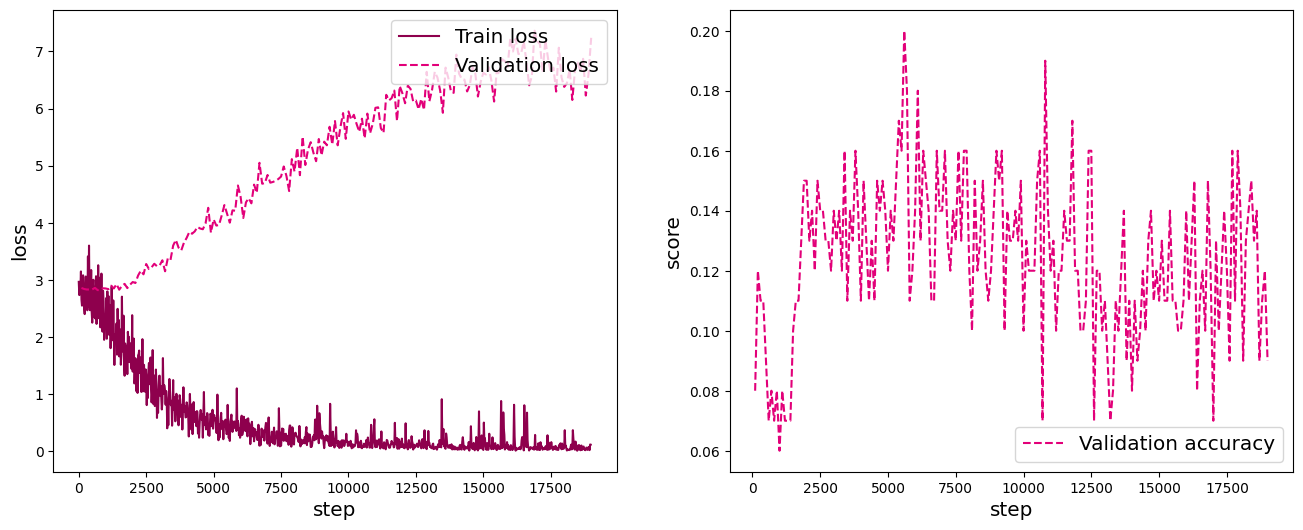

In [27]:
from pre_methods import plot_training_loss_acc
for length in [10, 15, 20, 25, 30, 35]:
    data_path = f'./dataset/srn_eval/{length}'
    train_examples, dev_examples, test_examples = load_data(data_path)
    train_set, dev_set, test_set = DigitSumDataset(train_examples), DigitSumDataset(dev_examples), DigitSumDataset(test_examples)
    train_loader, dev_loader, test_loader = DataLoader(train_set, batch_size), DataLoader(dev_set, batch_size), DataLoader(test_set, batch_size)
    base_model = SRN(input_size, hidden_size)
    model = Model_RNN4SeqClass(base_model, num_digits, input_size, hidden_size, num_classes)
    optimizer = torch.optim.Adam(lr=0.001, params=model.parameters())

    from pre_methods import Accuracy, RunnerV3
    metric = Accuracy()
    loss_fn = nn.CrossEntropyLoss()

    runner = RunnerV3(model, optimizer, metric, loss_fn)

    save_dir = f"./checkpoint_SRN_digit/{length}"
    runner.train(train_dataloader=train_loader, val_dataloader=dev_loader, num_epochs=500, eval_steps=100, log_steps=100,
                save_dir=save_dir)
    if length == 10:
        plot_training_loss_acc(runner)
        break

Evaluate SRN with data length 10
val_loss: 4.231148426349346, total_loss: 55.004929542541504, len: 13
val_loss: 4.453114454562847, total_loss: 57.89048790931702, len: 13
[SRN] length: 10, Dev Score:  0.13000
[SRN] length: 10, Test Score:  0.15000
Evaluate SRN with data length 15
val_loss: 4.300677042741042, total_loss: 55.908801555633545, len: 13
val_loss: 4.616314026025625, total_loss: 60.01208233833313, len: 13
[SRN] length: 15, Dev Score:  0.14000
[SRN] length: 15, Test Score:  0.13000
Evaluate SRN with data length 20
val_loss: 6.493671142137968, total_loss: 84.41772484779358, len: 13
val_loss: 6.563781114724966, total_loss: 85.32915449142456, len: 13
[SRN] length: 20, Dev Score:  0.09000
[SRN] length: 20, Test Score:  0.08000
Evaluate SRN with data length 25
val_loss: 3.7796718890850363, total_loss: 49.13573455810547, len: 13
val_loss: 3.960494096462543, total_loss: 51.48642325401306, len: 13
[SRN] length: 25, Dev Score:  0.05000
[SRN] length: 25, Test Score:  0.07000
Evaluate SRN 

e:\DesktopFile\tempCode\PythonCode\torch_practice_fudan\pre_methods.py:152: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  


Evaluate SRN with data length 35
val_loss: 2.9014626282912035, total_loss: 37.719014167785645, len: 13
val_loss: 2.875245589476365, total_loss: 37.37819266319275, len: 13
[SRN] length: 35, Dev Score:  0.15000
[SRN] length: 35, Test Score:  0.06000


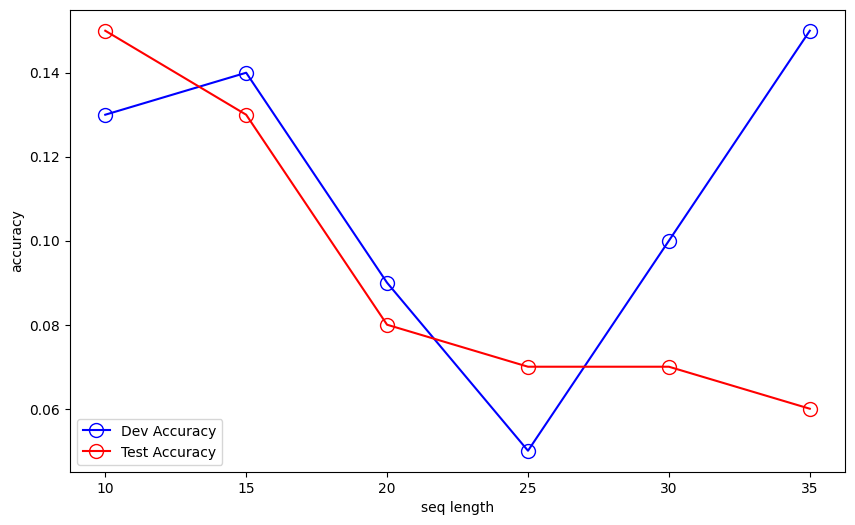

In [28]:
from matplotlib import pyplot as plt
lens = [10, 15, 20, 25, 30, 35]
dev_scores = []
test_scores = []
for length in lens:
    data_path = f'./dataset/srn_eval/{length}'
    train_examples, dev_examples, test_examples = load_data(data_path)
    train_set, dev_set, test_set = DigitSumDataset(train_examples), DigitSumDataset(dev_examples), DigitSumDataset(test_examples)
    train_loader, dev_loader, test_loader = DataLoader(train_set, batch_size), DataLoader(dev_set, batch_size), DataLoader(test_set, batch_size)
    base_model = SRN(input_size, hidden_size)
    model = Model_RNN4SeqClass(base_model, num_digits, input_size, hidden_size, num_classes)
    optimizer = torch.optim.Adam(lr=0.001, params=model.parameters())

    from pre_methods import Accuracy, RunnerV3
    metric = Accuracy()
    loss_fn = nn.CrossEntropyLoss()

    runner = RunnerV3(model, optimizer, metric, loss_fn)
    print(f"Evaluate SRN with data length {length}")
    model_path = os.path.join(f'./checkpoint_SRN_digit/{length}', 'model.pt')
    runner.load_model(model_path)
    test_score, _ = runner.evaluate(test_loader)
    test_scores.append(test_score)
    dev_score, _ = runner.evaluate(dev_loader)
    dev_scores.append(dev_score)
    print(f"[SRN] length: {length}, Dev Score: {dev_score: .5f}")
    print(f"[SRN] length: {length}, Test Score: {test_score: .5f}")


plt.rcParams['figure.figsize'] = (10.0, 6.0)
plt.plot(lens, dev_scores, 'o-', mfc="none", mec="b", ms=10, c="b", label="Dev Accuracy")
plt.plot(lens, test_scores, 'o-', mfc="none", mec="r", ms=10, c="r", label="Test Accuracy")
plt.legend()
plt.xlabel("seq length")
plt.ylabel("accuracy")
plt.show()

## 6.2 梯度爆炸实验

In [29]:
from numpy.linalg import norm
W_grad = []
U_grad = []
b_grad = []
def custom_print_log(model):
    W_grad_12, U_grad_12, b_grad_12 = 0, 0, 0
    for name, param in model.named_parameters():
        if name == "run_model.W":
            W_grad_12 = norm(param.grad)
            W_grad.append(W_grad_12)
        if name == "run_model.U":
            U_grad_12 = norm(param.grad)
            U_grad.append(U_grad_12)
        if name == "run_model.b":
            b_grad_12 = norm(param.grad)
            b_grad.append(b_grad_12)
    print(f"[Training] W_grad_12: {W_grad_12: .5f}, U_grad_12: {U_grad_12: .5f}, b_grad_12: {b_grad_12: .5f}")

[Train] epoch: 0/20, step: 0/100, loss: 193.74355
[Training] W_grad_12:  10.30873, U_grad_12:  31.32946, b_grad_12:  9.49708
[Train] epoch: 0/20, step: 1/100, loss: 212.52788
[Training] W_grad_12:  202.60175, U_grad_12:  479.46237, b_grad_12:  127.55644
[Train] epoch: 0/20, step: 2/100, loss: 806.02478
[Training] W_grad_12:  599.90845, U_grad_12:  157.66933, b_grad_12:  28.12086
[Train] epoch: 0/20, step: 3/100, loss: 1352.75256
[Training] W_grad_12:  50.14896, U_grad_12:  16.29301, b_grad_12:  2.89476
[Train] epoch: 0/20, step: 4/100, loss: 2134.23364
[Training] W_grad_12:  5.31348, U_grad_12:  4.39563, b_grad_12:  0.77705
[Train] epoch: 1/20, step: 5/100, loss: 8162.27637
[Training] W_grad_12:  119.83421, U_grad_12:  111.42936, b_grad_12:  19.69811
[Train] epoch: 1/20, step: 6/100, loss: 8079.25684
[Training] W_grad_12:  9143.08203, U_grad_12:  1355.31519, b_grad_12:  243.37132
[Train] epoch: 1/20, step: 7/100, loss: 7686.92676
[Training] W_grad_12:  48.89722, U_grad_12:  40.93853, b

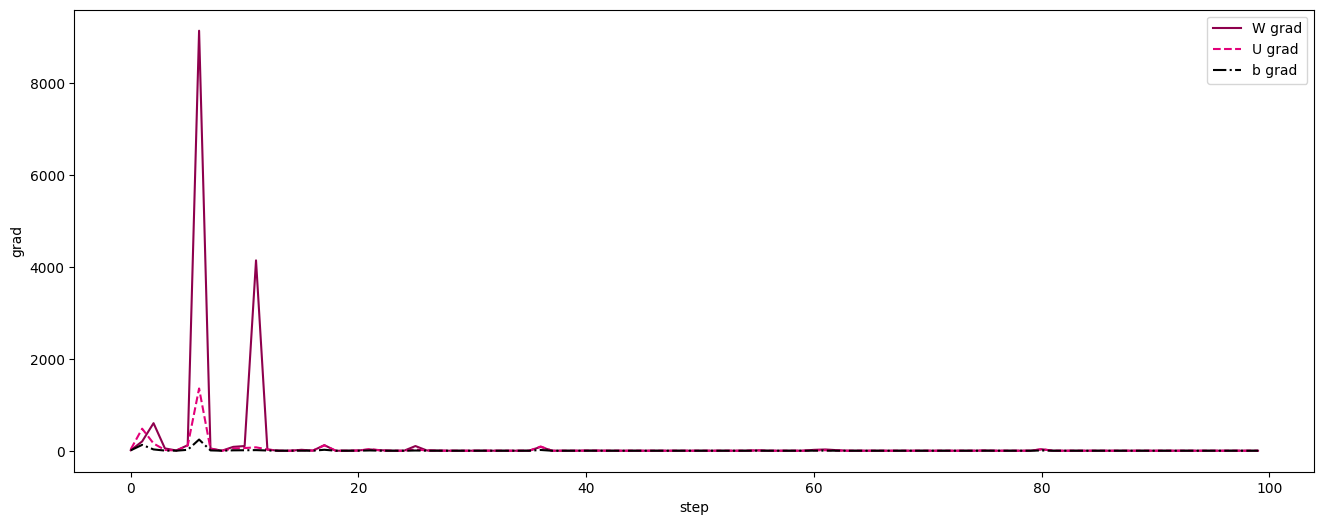

In [35]:
import os
import numpy as np
import random
import torch
import matplotlib.pyplot as plt
np.random.seed(0)
random.seed(0)
torch.manual_seed(0)

num_digits = 10
input_size = 32
hidden_size = 32
num_classes = 19
batch_size = 64
length = 20

data_path = f'./dataset/srn_eval/{length}'
train_examples, dev_examples, test_examples = load_data(data_path)
train_set, dev_set, test_set = DigitSumDataset(train_examples), DigitSumDataset(dev_examples), DigitSumDataset(test_examples)
train_loader, dev_loader, test_loader = DataLoader(train_set, batch_size), DataLoader(dev_set, batch_size), DataLoader(test_set, batch_size)
base_model = SRN(input_size, hidden_size)
model = Model_RNN4SeqClass(base_model, num_digits, input_size, hidden_size, num_classes)
optimizer = torch.optim.SGD(lr=0.2, params=model.parameters())

from pre_methods import Accuracy, RunnerV3
metric = Accuracy()
loss_fn = nn.CrossEntropyLoss(reduction='sum')

runner = RunnerV3(model, optimizer, metric, loss_fn)
W_grad = []
U_grad = []
b_grad = []
save_dir = f"./checkpoint_SRN_explosion/{length}"
runner.train(train_dataloader=train_loader, val_dataloader=dev_loader, num_epochs=20, eval_steps=100, log_steps=1,
            save_dir=save_dir, custom_print_log=custom_print_log)

plt.figure(figsize=(16, 6))
plt.plot(range(len(W_grad)), W_grad, color="#8E004D", linestyle='-', label="W grad")
plt.plot(range(len(W_grad)), U_grad, color="#E20079", linestyle='--', label="U grad")
plt.plot(range(len(W_grad)), b_grad, color="#000000", linestyle='-.', label="b grad")
plt.legend()
plt.xlabel("step")
plt.ylabel("grad")
plt.show()

[Train] epoch: 0/20, step: 0/100, loss: 193.05014
[Training] W_grad_12:  6.73912, U_grad_12:  17.94536, b_grad_12:  5.52593
[Train] epoch: 0/20, step: 1/100, loss: 197.57373
[Training] W_grad_12:  107.90043, U_grad_12:  211.73285, b_grad_12:  66.16778
[Train] epoch: 0/20, step: 2/100, loss: 831.98889
[Training] W_grad_12:  1284.63379, U_grad_12:  523.46387, b_grad_12:  94.70164
[Train] epoch: 0/20, step: 3/100, loss: 1474.38843
[Training] W_grad_12:  682.26105, U_grad_12:  383.70685, b_grad_12:  61.82893
[Train] epoch: 0/20, step: 4/100, loss: 1609.42212
[Training] W_grad_12:  828.62177, U_grad_12:  193.26509, b_grad_12:  35.25437
[Train] epoch: 1/20, step: 5/100, loss: 4398.96875
[Training] W_grad_12:  199.30241, U_grad_12:  51.88939, b_grad_12:  9.51871
[Train] epoch: 1/20, step: 6/100, loss: 1496.21277
[Training] W_grad_12:  60.98879, U_grad_12:  87.01660, b_grad_12:  15.38632
[Train] epoch: 1/20, step: 7/100, loss: 3021.60254
[Training] W_grad_12:  31.35217, U_grad_12:  13.46236, b

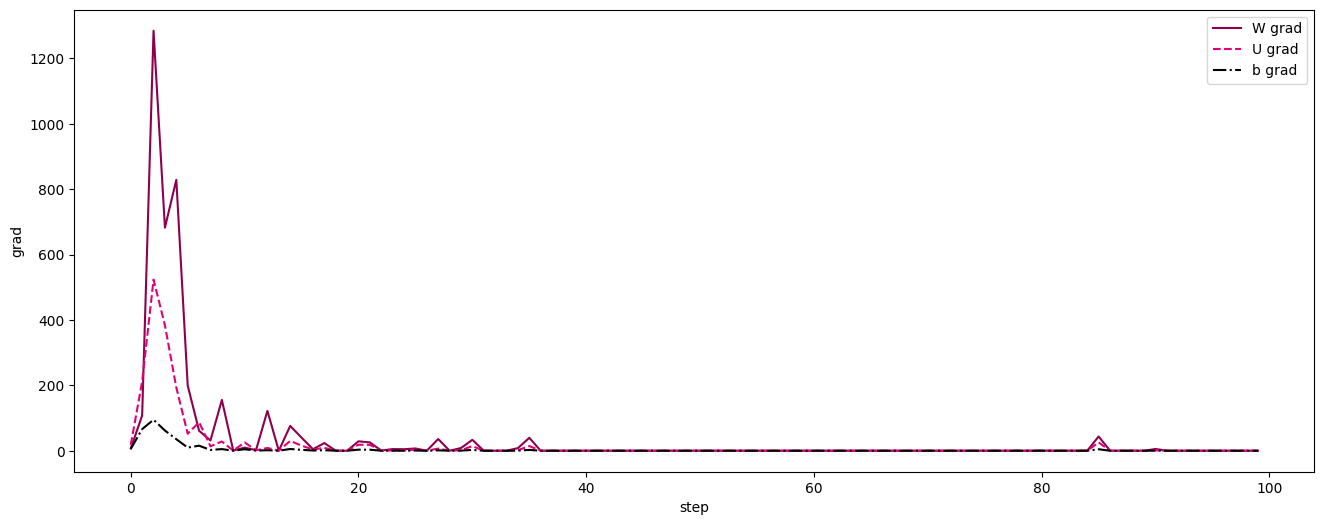

In [36]:
from pre_methods import Accuracy, RunnerV3
base_model = SRN(input_size, hidden_size)
model = Model_RNN4SeqClass(base_model, num_digits, input_size, hidden_size, num_classes)
optimizer = torch.optim.SGD(lr=0.2, params=model.parameters())
metric = Accuracy()
loss_fn = nn.CrossEntropyLoss(reduction='sum')
runner = RunnerV3(model, optimizer, metric, loss_fn)
W_grad = []
U_grad = []
b_grad = []
save_dir = f"./checkpoint_SRN_clip/{length}"
runner.train(train_dataloader=train_loader, val_dataloader=dev_loader, num_epochs=20, eval_steps=100, log_steps=1,
            save_dir=save_dir, custom_print_log=custom_print_log, grad_clip=0.5)

plt.figure(figsize=(16, 6))
plt.plot(range(len(W_grad)), W_grad, color="#8E004D", linestyle='-', label="W grad")
plt.plot(range(len(W_grad)), U_grad, color="#E20079", linestyle='--', label="U grad")
plt.plot(range(len(W_grad)), b_grad, color="#000000", linestyle='-.', label="b grad")
plt.legend()
plt.xlabel("step")
plt.ylabel("grad")
plt.show()

## 6.3 LSTM

## 6.4 基于双向LSTM模型完成文本分类任务

In [ ]:
import os
def load_imdb_data(data_dir):
    train_dir = os.path.join(data_dir, 'train')
    test_dir = os.path.join(data_dir, 'test')
    with open(""):